In [18]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import proj_functions as pf
from keyword_col_names import keyword_col_names as kc

In [128]:
df = pd.read_csv('data/cleanedData_v2.csv')

In [129]:
#remove per capita columns
#create a list of keywords to highlight columns to remove
keywords = ['energy_per_capita','cons_per_capita', 'consumption', 'change_twh', 'production']

colns_to_remove = kc(df, keywords)

In [130]:
df.drop(colns_to_remove, axis=1, inplace=True)

In [131]:
share_cols = kc(df, ['share_energy'])

In [132]:
share_cols.append('emissions_per_capita')
share_cols.append('gdp_per_capita')

In [133]:
remove_cols = ['fossil_share_energy','low_carbon_share_energy','other_renewables_share_energy','renewables_share_energy']

for col in remove_cols:
    share_cols.remove(col)

In [199]:
df['emissions_per_capita'] = df['greenhouse_gas_emissions'] / df['population'] * 1e9

In [135]:
df['gdp_per_capita'] = df['gdp'] / df['population']

In [140]:
df = df.loc[df['year'] >= 2000]

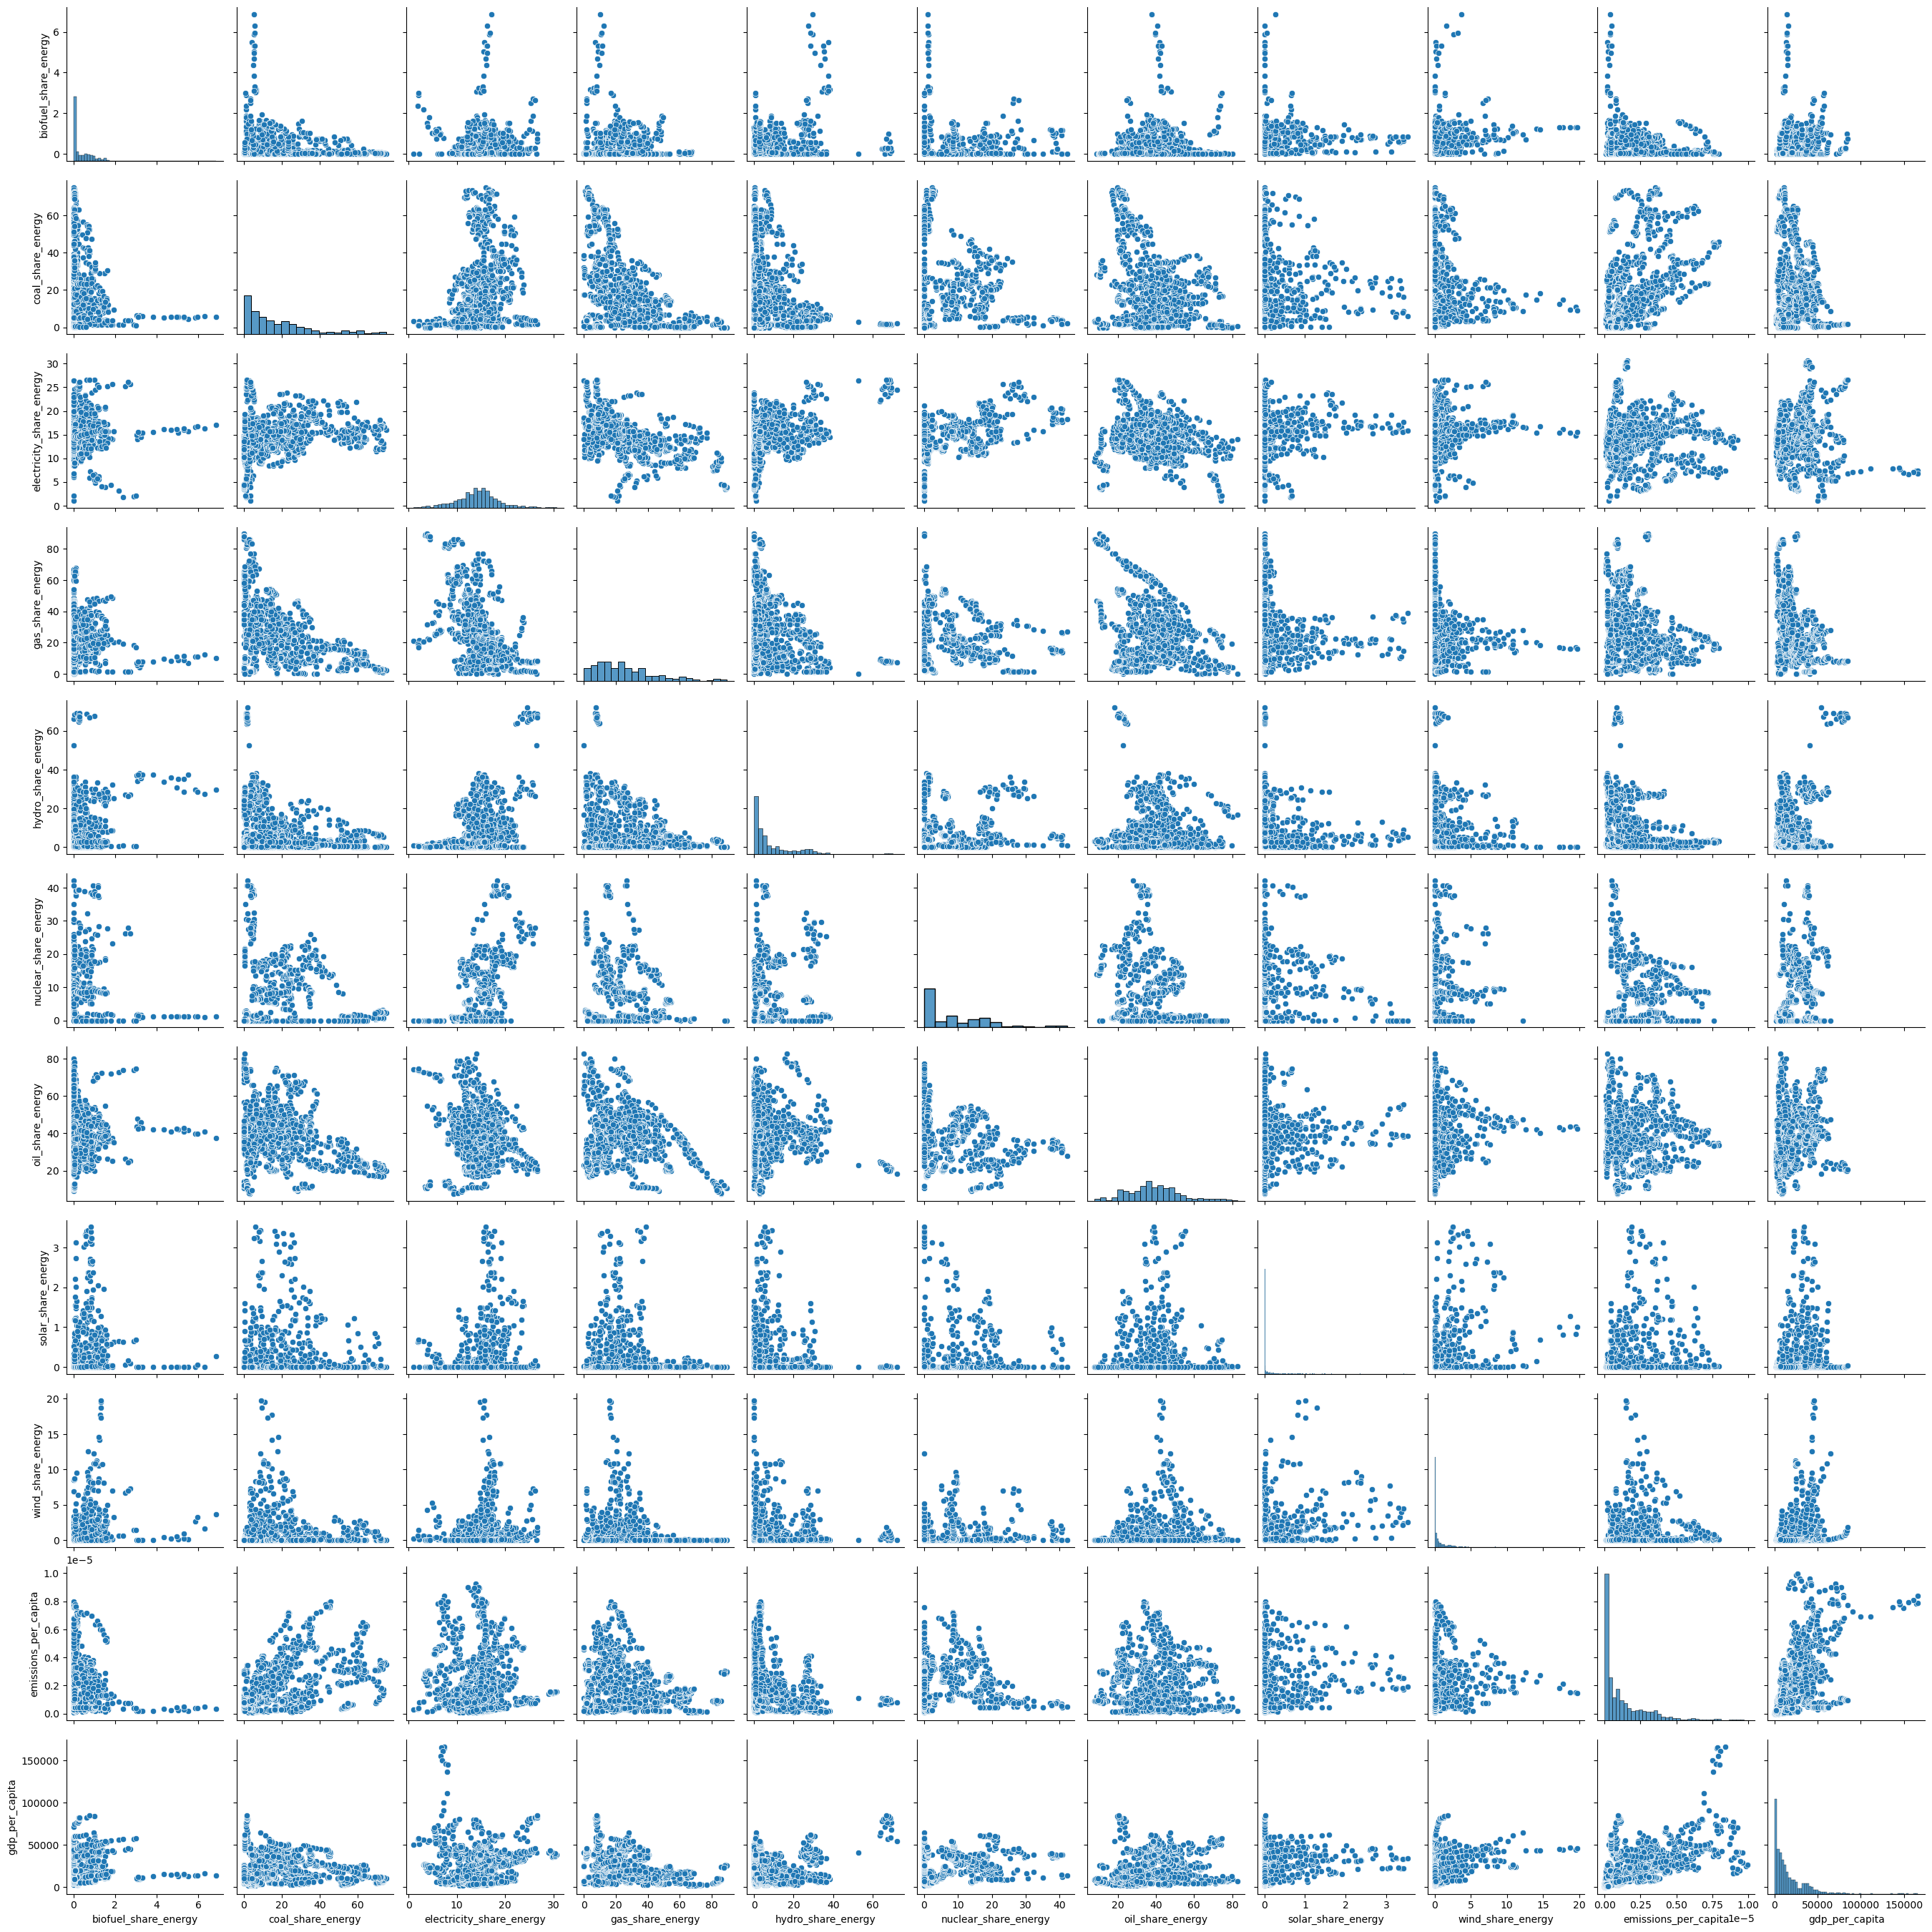

In [68]:
sns.pairplot(df[share_cols], diag_kind='hist')

<Axes: >

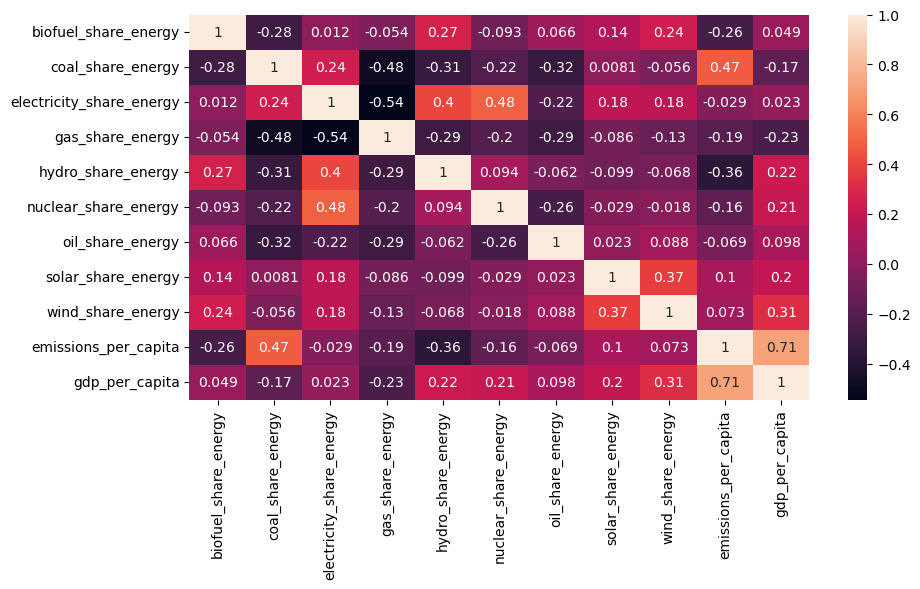

In [141]:
plt.figure(figsize=(10,5))
sns.heatmap(df[share_cols].corr(), annot=True)

In [137]:
#filter by corr values
C = df[share_cols].corr()

C = C.replace(1,0)

idxs = np.argmax(C.values, axis=1)

In [138]:
for i in range(len(C)):
    for j in range(i+1, len(C)):
        C.iat[i, j] = 0

In [142]:
# Create a boolean mask for values greater than 0.1
mask = abs(C) > 0.3

# Use .where() to get the locations of values greater than 0.1
locations = mask.stack().reset_index()
locations.columns = ['Row', 'Column', 'Value']

# Filter for values greater than 0.1
filtered_locations = locations[locations['Value']]

# Print the locations
print(filtered_locations)

                      Row                    Column  Value
34       gas_share_energy         coal_share_energy   True
35       gas_share_energy  electricity_share_energy   True
44     hydro_share_energy      biofuel_share_energy   True
45     hydro_share_energy         coal_share_energy   True
46     hydro_share_energy  electricity_share_energy   True
57   nuclear_share_energy  electricity_share_energy   True
67       oil_share_energy         coal_share_energy   True
95      wind_share_energy        solar_share_energy   True
100  emissions_per_capita         coal_share_energy   True
103  emissions_per_capita        hydro_share_energy   True
115        gdp_per_capita      nuclear_share_energy   True
118        gdp_per_capita         wind_share_energy   True
119        gdp_per_capita      emissions_per_capita   True


In [143]:
sampled_df = pd.DataFrame(columns=['emissions_per_capita', 'gdp_per_capita'])

In [144]:
import random

In [218]:
df.dropna(inplace=True)

sampled_df = pd.DataFrame(columns=['emissions_per_capita', 'gdp_per_capita', 'year'])

sampled_df = sampled_df.loc[sampled_df['year'] >= 2000].drop('year', axis=1)
# Specify the number of rows you want to sample
num_samples = 192  # Adjust this to your desired number of samples

# Sample rows without replacement
sampled_rows = df.sample(n=num_samples, replace=False)

# Concatenate the sampled rows to the sampled_df
sampled_df = pd.concat([sampled_df, sampled_rows])


C:\Users\Adrian\AppData\Local\Temp\ipykernel_36204\1283643390.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled_df = pd.concat([sampled_df, sampled_rows])


<Axes: xlabel='gdp_per_capita', ylabel='emissions_per_capita'>

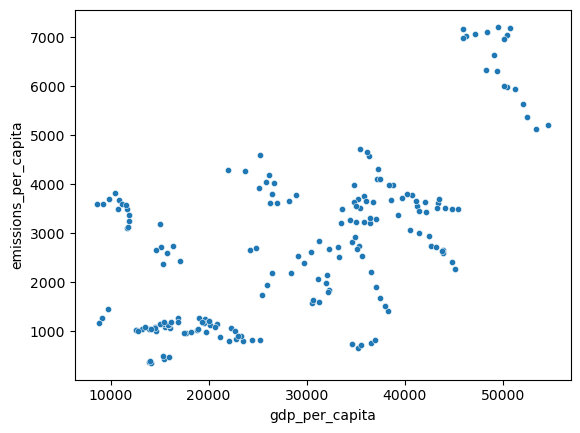

In [219]:
sns.scatterplot(y='emissions_per_capita', x='gdp_per_capita', data=sampled_df, s=20)

In [220]:
sampled_df = sampled_df.loc[:, ['emissions_per_capita', 'gdp_per_capita']].copy()

In [223]:
# Fit the quadratic regression model
X = sampled_df['gdp_per_capita']
y = sampled_df['emissions_per_capita']



In [224]:
model = sm.OLS(y, X).fit()
# Print model summary
print(model.summary())

                                  OLS Regression Results                                 
Dep. Variable:     emissions_per_capita   R-squared (uncentered):                   0.841
Model:                              OLS   Adj. R-squared (uncentered):              0.840
Method:                   Least Squares   F-statistic:                              1012.
Date:                  Thu, 30 Nov 2023   Prob (F-statistic):                    3.04e-78
Time:                          03:14:20   Log-Likelihood:                         -1649.0
No. Observations:                   192   AIC:                                      3300.
Df Residuals:                       191   BIC:                                      3303.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------

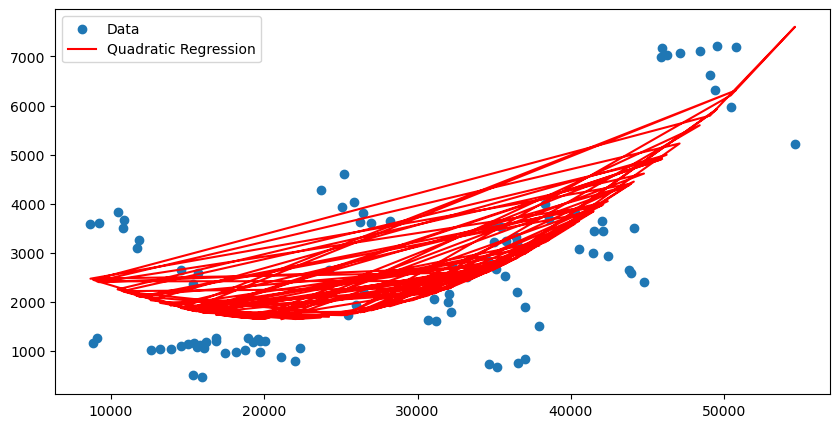

In [177]:
predicted_values = model.predict(sampled_df)

# Plot the original data and the regression curve
plt.figure(figsize=(10, 5))
plt.scatter(sampled_df['gdp_per_capita'], sampled_df['emissions_per_capita'], label='Data')
plt.plot(sampled_df['gdp_per_capita'], predicted_values, color='red', label='Quadratic Regression')
plt.legend()
plt.show()